<a href="https://www.kaggle.com/jaimemorillo/genre-prediction?scriptVersionId=86341756" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [57]:
import pandas as pd 
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.metrics
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFDistilBertForSequenceClassification
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
tmdb_df = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv', index_col='id')
netflix_df = pd.read_csv('../input/netflix-shows/netflix_titles.csv', index_col='show_id')

# Preprocessing

In [3]:
tmdb_df = tmdb_df.loc[:,['overview','genres']]
tmdb_df = tmdb_df.dropna(subset=['overview', 'genres'])

netflix_df = netflix_df.loc[:,['description', 'listed_in']]
netflix_df = netflix_df.dropna(subset=['description', 'listed_in'])
netflix_df['listed_in'] = netflix_df['listed_in'].str.split(',')
netflix_df['listed_in'] = netflix_df['listed_in'].apply(lambda x: [i.strip() for i in x])
netflix_df = netflix_df.rename(columns={'description': 'overview', 'listed_in':'genres'})

def parse_genres(genres_string):
    genres_dict = eval(genres_string)
    genres = [i['name'] for i in genres_dict]
    return genres

tmdb_df['genres'] = tmdb_df['genres'].apply(lambda x: parse_genres(x))

Map genres for combined them

In [4]:
genres_netflix_map = {
    'Dramas': 'Drama',
    'Comedies': 'Comedy',
    'Action & Adventure': 'Action & Adventure',
    'Documentaries': 'Documentary',
    'TV Dramas': 'Drama',
    'Children & Family Movies': 'Family',
    'Romantic Movies': 'Romance',
    'TV Comedies': 'Comedy',
    'Thrillers': 'Thriller',
    'Crime TV Shows': 'Crime',
    "Kids' TV": 'Animation',
    'Docuseries': 'Documentary',
    'Music & Musicals': 'Music',
    'Romantic TV Shows': 'Romance',
    'Horror Movies': 'Horror',
    'Stand-Up Comedy': 'Comedy',
    'Sci-Fi & Fantasy': 'Science Fiction & Fantasy',
    'Anime Series': 'Animation',
    'TV Action & Adventure': 'Action & Adventure',
    'Science & Nature TV': 'Documentary',
    'TV Sci-Fi & Fantasy': 'Science Fiction & Fantasy',
    'TV Horror': 'Horror',
    'Anime Features': 'Animation',
    'TV Thrillers': 'Thriller',
    'Stand-Up Comedy & Talk Shows': 'Comedy'
}

genres_tmdb_map = {
    'Science Fiction': 'Science Fiction & Fantasy',
    'Fantasy': 'Science Fiction & Fantasy',
    'Action': 'Action & Adventure',
    'Adventure': 'Action & Adventure'
}

netflix_df['genres'] = netflix_df['genres'].apply(lambda x: [genres_netflix_map.get(i) for i in x if genres_netflix_map.get(i) is not None])
tmdb_df['genres'] = tmdb_df['genres'].apply(lambda x: [genres_tmdb_map.get(i) if genres_tmdb_map.get(i) is not None else i for i in x ])
df = tmdb_df.append(netflix_df)
df.reset_index(inplace=True, drop=True)

In [5]:
mlb = MultiLabelBinarizer()
genres_binary = mlb.fit_transform(df['genres'])
genres = pd.DataFrame(genres_binary, columns=mlb.classes_, index=df.index)

In [6]:
df = df.join(genres).drop(['genres', 'Foreign', 'History', 'War', 'Western', 'TV Movie', 'Mystery'],axis=1)
df = df[df.sum(axis=1)!=0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


<AxesSubplot:>

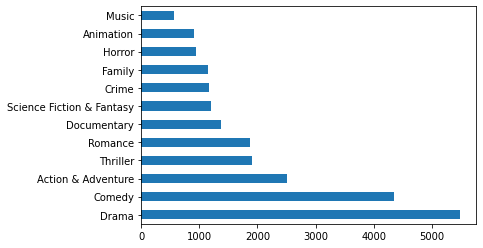

In [7]:
df.iloc[:,1:].sum().sort_values(ascending=False).plot(kind='barh')

In [8]:
df.shape

(13282, 13)

# Model

In [39]:
X = df.overview
y = df.drop(['overview'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [10]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Example

In [22]:
text = X_train.iloc[0]
encoded_input = tokenizer(text)

print('Original text: '+ text)
print('Tokens: ' + str(encoded_input))
print('Reverse tokens: ' + tokenizer.decode(encoded_input["input_ids"]))

Original text: This series looks at how seasonal changes cause shifting weather patterns and ocean currents, creating the conditions for spectacular wildlife events.
Tokens: {'input_ids': [101, 2023, 2186, 3504, 2012, 2129, 12348, 3431, 3426, 9564, 4633, 7060, 1998, 4153, 14731, 1010, 4526, 1996, 3785, 2005, 12656, 6870, 2824, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Reverse tokens: [CLS] this series looks at how seasonal changes cause shifting weather patterns and ocean currents, creating the conditions for spectacular wildlife events. [SEP]


In [40]:
batch_sentences = X_train.values.tolist()
X_train = tokenizer(batch_sentences, padding='max_length', max_length=225, truncation=True, return_tensors="tf")
X_train['targets'] = np.array(y_train)

batch_sentences = X_test.values.tolist()
X_test = tokenizer(batch_sentences, padding='max_length', max_length=225, truncation=True, return_tensors="tf")
X_test['targets'] = np.array(y_test)

print(X_train)
print(tokenizer.decode(X_train["input_ids"][0]))

{'input_ids': <tf.Tensor: shape=(10625, 225), dtype=int32, numpy=
array([[ 101, 2023, 2186, ...,    0,    0,    0],
       [ 101, 1037, 2305, ...,    0,    0,    0],
       [ 101, 5148, 8003, ...,    0,    0,    0],
       ...,
       [ 101, 2043, 2010, ...,    0,    0,    0],
       [ 101, 2023, 4516, ...,    0,    0,    0],
       [ 101, 2043, 1037, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(10625, 225), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'targets': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])}
[CLS] this series looks at how seasonal changes cause shifting weather patterns and ocean currents,

In [41]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                              num_labels=len(y_train.columns), 
                                                              problem_type="multi_label_classification")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_59', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [42]:
train_features = {x: X_train[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, X_train["targets"]))
train_tf_dataset = train_tf_dataset.shuffle(len(X_train)).batch(32)

test_features = {x: X_test[x] for x in tokenizer.model_input_names}
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_features, X_test["targets"]))
test_tf_dataset = test_tf_dataset.batch(32)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.TopKCategoricalAccuracy(k=2),
)

model.fit(train_tf_dataset, validation_data=test_tf_dataset, epochs=3)

Epoch 1/3
267/333 [=======================>......] - ETA: 28s - loss: 0.1290 - top_k_categorical_accuracy: 0.9469

In [45]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

y_pred_logits = model.predict(test_tf_dataset)
y_pred_proba = inv_logit(y_pred_logits[0])

Logits to labels 
https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow

Probability of 0.5 corresponds to a logit of 0. Negative logit correspond to probabilities less than 0.5, positive to > 0.5.

In [46]:
predictions = pd.DataFrame(y_pred_proba, columns=y_test.columns, index=y_test.index).copy()
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0

In [56]:
y_test

,Action & Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Horror,Music,Romance,Science Fiction & Fantasy,Thriller
2463,0,0,0,0,0,1,0,0,0,0,0,0
8792,0,0,1,0,0,1,0,0,0,0,0,0
2758,0,0,1,0,0,0,0,0,0,1,0,0
3293,0,0,1,1,0,1,0,0,0,1,0,0
6253,0,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3753,0,0,1,0,0,0,0,0,0,0,0,0
11242,0,0,0,0,1,0,0,0,0,0,0,0
7497,0,0,0,0,0,1,0,0,0,0,0,0
2534,0,0,0,0,0,0,0,1,0,0,0,1


In [48]:
predictions

,Action & Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Horror,Music,Romance,Science Fiction & Fantasy,Thriller
2463,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8792,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2758,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3293,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6253,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3753,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11242,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7497,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

https://stackoverflow.com/questions/31311154/explanation-for-coverage-error-metric-in-scikit-learn

https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics

In [58]:
sklearn.metrics.coverage_error(y_test, y_pred_proba)

3.0

In [59]:
sklearn.metrics.label_ranking_average_precision_score(y_test, y_pred_proba)

0.7985644624824134

In [60]:
sklearn.metrics.label_ranking_loss(y_test, y_pred_proba)

0.08392831006445986

In [61]:
sklearn.metrics.ndcg_score(y_test, y_pred_proba)

0.8644143287520318

In [62]:
print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_test, predictions)))

print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_test, predictions))) 

#"samples" applies only to multilabel problems. It does not calculate a per-class measure, instead calculating the metric over the true and predicted classes 
#for each sample in the evaluation data, and returning their (sample_weight-weighted) average.

print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test, y_pred=predictions, average='samples'))) 

print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test, y_pred=predictions, average='samples')))

print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test, y_pred=predictions, average='samples'))) 

Exact Match Ratio: 0.33421151674821226
Hamming loss: 0.09939154434826244
Recall: 0.7016936394429808
Precision: 0.621321038765525
F1 Measure: 0.6282876618217229


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
confusion_matrix = sklearn.metrics.multilabel_confusion_matrix(y_test, predictions)
for idx,i in enumerate(confusion_matrix):
    print(y_test.columns[idx] + ' ----------------------------------------------------------------------')
    print('Acc: {0}'.format(sklearn.metrics.accuracy_score(y_test.iloc[:,idx], predictions.iloc[:,idx])))
    print('F1-score: {0}'.format(sklearn.metrics.f1_score(y_test.iloc[:,idx], predictions.iloc[:,idx])))
    print(i)

Action & Adventure ----------------------------------------------------------------------
Acc: 0.8690252164094844
F1-score: 0.6027397260273973
[[2045  116]
 [ 232  264]]
Animation ----------------------------------------------------------------------
Acc: 0.9458035378246142
F1-score: 0.558282208588957
[[2422   46]
 [  98   91]]
Comedy ----------------------------------------------------------------------
Acc: 0.8110651110274746
F1-score: 0.6979542719614923
[[1575  238]
 [ 264  580]]
Crime ----------------------------------------------------------------------
Acc: 0.9175762137749341
F1-score: 0.3615160349854228
[[2376   44]
 [ 175   62]]
Documentary ----------------------------------------------------------------------
Acc: 0.9657508468197215
F1-score: 0.8017429193899782
[[2382   18]
 [  73  184]]
Drama ----------------------------------------------------------------------
Acc: 0.7730523146405721
F1-score: 0.7255348202093764
[[1257  275]
 [ 328  797]]
Family ----------------------------